In [12]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn as sk
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
# for SVM
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# from common_func import plot_decision_regions
import seaborn as sns

データの読み込み

In [13]:
df = pd.read_csv("ks-projects-201801.csv")

In [14]:
display(df.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [15]:
#内容確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


可視化

In [16]:
#散布図行列
# pd.plotting.scatter_matrix(ks, figsize=(10,10))
# plt.show() #時間かかる

In [17]:
#相関係数
df.corr()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
ID,1.000000,0.001679,0.000466,0.000654,-0.000633,-0.000025,0.001854
goal,0.001679,1.000000,0.007358,0.004012,0.005534,0.005104,0.942692
pledged,0.000466,0.007358,1.000000,0.717079,0.857370,0.952843,0.005024
backers,0.000654,0.004012,0.717079,1.000000,0.697426,0.752539,0.004517
usd pledged,-0.000633,0.005534,0.857370,0.697426,1.000000,0.907743,0.006172
usd_pledged_real,-0.000025,0.005104,0.952843,0.752539,0.907743,1.000000,0.005596
usd_goal_real,0.001854,0.942692,0.005024,0.004517,0.006172,0.005596,1.000000


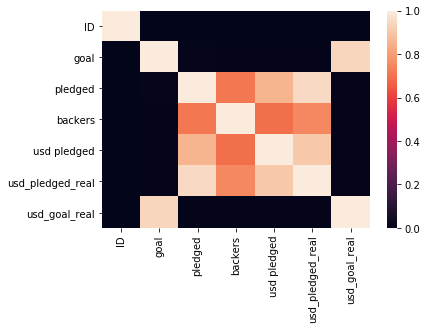

In [18]:
sns.heatmap(df.corr())
plt.show()

count    3.786610e+05
mean     4.545440e+04
std      1.152950e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.500000e+03
75%      1.550000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64


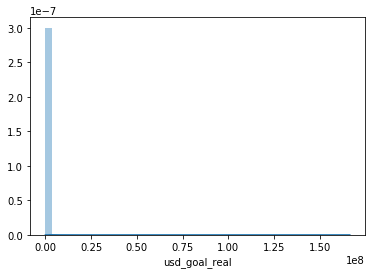

In [19]:
#量的変数に関しては必ずヒストグラム等で分布を確認すること
print(df["usd_goal_real"].describe())
#ヒストグラム
sns.distplot(df["usd_goal_real"])

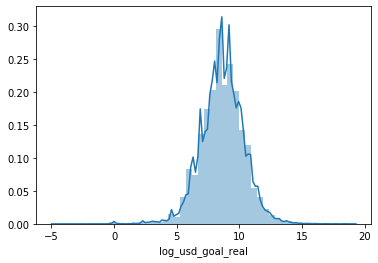

In [20]:
#対数表示
df["log_usd_goal_real"]=np.log(df["usd_goal_real"])
sns.distplot(df["log_usd_goal_real"])

In [21]:
#min,maxを具体的に見てみる
print(df["usd_goal_real"].nlargest(5))
print(df["usd_goal_real"].nsmallest(5))

47803     1.663614e+08
196531    1.513959e+08
367928    1.101698e+08
222208    1.073699e+08
226161    1.040572e+08
Name: usd_goal_real, dtype: float64
304489    0.01
317771    0.01
370401    0.15
74446     0.49
226171    0.50
Name: usd_goal_real, dtype: float64


前処理<br>
・不要なカラム削除<br>
・launchedからdeadlineを引いて期間を作成<br>
・stateのsussessful,failed以外は頻度を見て少なければ除外<br>
・カテゴリカル変数に変換<br>

In [22]:
# 不要なカラムを削除
# pledged, backers を削除 これらは達成後の指標のため
# currency, goal を削除 代わりにusd_goal_realを使う
rm_col = ['ID','name','currency','goal','backers','pledged','usd pledged','usd_pledged_real']
df_rmcol=df.drop(rm_col, axis=1)

df_rmcol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   category           378661 non-null  object 
 1   main_category      378661 non-null  object 
 2   deadline           378661 non-null  object 
 3   launched           378661 non-null  object 
 4   state              378661 non-null  object 
 5   country            378661 non-null  object 
 6   usd_goal_real      378661 non-null  float64
 7   log_usd_goal_real  378661 non-null  float64
dtypes: float64(2), object(6)
memory usage: 23.1+ MB


In [23]:
# sateについて
df_rmcol.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [24]:
#KaggleのData Explorerでも見れるが、
#全体の12%と少々大きい気もするが、
#母数が13万件と予測に十分そうなので除外する
df_state = df_rmcol[ (df_rmcol['state'] == 'successful') | (df_rmcol['state'] == 'failed') ]
df_state.state.value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

In [25]:
#期間
#日時の取り扱いが良く分からず

rm_col2 = ['deadline','launched']
df_rmcol2=df_state.drop(rm_col2, axis=1)
df_rmcol2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   category           331675 non-null  object 
 1   main_category      331675 non-null  object 
 2   state              331675 non-null  object 
 3   country            331675 non-null  object 
 4   usd_goal_real      331675 non-null  float64
 5   log_usd_goal_real  331675 non-null  float64
dtypes: float64(2), object(4)
memory usage: 17.7+ MB


In [26]:
#カテゴリカル変数,boolean

#df_ks_data_all = pd.get_dummies(df_ks_data,  columns=dummy_items ,drop_first = True)
dummy = ['category','main_category','state','country']

df_set = pd.get_dummies(df_rmcol2, columns=dummy)
print(df_set.columns.values.tolist())

['usd_goal_real', 'log_usd_goal_real', 'category_3D Printing', 'category_Academic', 'category_Accessories', 'category_Action', 'category_Animals', 'category_Animation', 'category_Anthologies', 'category_Apparel', 'category_Apps', 'category_Architecture', 'category_Art', 'category_Art Books', 'category_Audio', 'category_Bacon', 'category_Blues', 'category_Calendars', 'category_Camera Equipment', 'category_Candles', 'category_Ceramics', "category_Children's Books", 'category_Childrenswear', 'category_Chiptune', 'category_Civic Design', 'category_Classical Music', 'category_Comedy', 'category_Comic Books', 'category_Comics', 'category_Community Gardens', 'category_Conceptual Art', 'category_Cookbooks', 'category_Country & Folk', 'category_Couture', 'category_Crafts', 'category_Crochet', 'category_DIY', 'category_DIY Electronics', 'category_Dance', 'category_Design', 'category_Digital Art', 'category_Documentary', 'category_Drama', 'category_Drinks', 'category_Electronic Music', 'category_

In [27]:
#Scikit-learnでロジスティック回帰
df=df_set.drop('state_failed', axis=1)
y = df['state_successful'].values
x = df.drop('state_successful', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(x, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='none',
              power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

#正答率（Accuracy） = 53.717%
#適合率（Precision） = 74.573%
#再現率（Recall） = 33.928%
#F1値（F1-score） = 46.638%

正答率（Accuracy） = 53.717%
適合率（Precision） = 74.573%
再現率（Recall） = 33.928%
F1値（F1-score） = 46.638%


In [29]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['真 NoGoal', '真 Goal'], 
                        columns=['予測 NoGoal', '予測 Goal'])
print(conf_mat)

          予測 NoGoal  予測 Goal
真 NoGoal      67083   130636
真 Goal        22873   111083


DAY1ここまで

<br>
<br>
<br>

<h1>DAY2</h1><br>
・正規化、標準化、無相関化、白色化を取り入れる<br>
・交差検証またはホールドアウト法を用いて、汎化性能を確認する<br>
・過学習への対処する<br>
・ハイパーパラメータの探索を行う<br>
・DAY1のモデルと精度を比較する<br>

In [19]:
# ホールドアウト法のためにデータ分割
dftrain, dftest = train_test_split(df, test_size=0.2, random_state=0)

後の比較のためにDAY1と同じ手順でdftrainでの結果を出しておく

In [167]:
y = dftrain['state_successful'].values
x = dftrain.drop('state_successful', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(x, y)

# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 54.778%
適合率（Precision） = 72.897%
再現率（Recall） = 38.346%
F1値（F1-score） = 50.256%


<h2>標準化、正規化を取り入れる</h2>

In [168]:
# 標準化
df_std = dftrain.copy()
df_std["usd_goal_real"] =  (df_std["usd_goal_real"] - df_std["usd_goal_real"].mean()) / df_std["usd_goal_real"].std(ddof=0)

standardscalerを使いたいがdataframeに使うには手間<br>
sklearn_pandasが便利そうだが指定環境に無いのではベタ書きで良さそう<br>

In [169]:
# ロジスティック回帰
y = df_std['state_successful'].values
x = df_std.drop('state_successful', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(x, y)

# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 66.709%
適合率（Precision） = 69.911%
再現率（Recall） = 77.450%
F1値（F1-score） = 73.488%


In [170]:
# 正規化
df_norm = dftrain.copy()
df_norm["usd_goal_real"] = (df_norm["usd_goal_real"] - df_norm["usd_goal_real"].min()) / (df_norm["usd_goal_real"].max() - df_norm["usd_goal_real"].min())

# ロジスティック回帰
y = df_norm['state_successful'].values
x = df_norm.drop('state_successful', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(x, y)

# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))


正答率（Accuracy） = 66.778%
適合率（Precision） = 68.894%
再現率（Recall） = 80.645%
F1値（F1-score） = 74.308%


In [171]:
# 標準化⇒正規化
df_std_norm=df_std.copy()
df_std_norm["usd_goal_real"] = (df_std["usd_goal_real"] - df_std["usd_goal_real"].min()) / (df_std["usd_goal_real"].max() - df_std["usd_goal_real"].min())

# ロジスティック回帰
y = df_std_norm['state_successful'].values
x = df_std_norm.drop('state_successful', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(x, y)

# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 66.778%
適合率（Precision） = 68.894%
再現率（Recall） = 80.645%
F1値（F1-score） = 74.308%


In [84]:
# 正規化⇒標準化
df_norm_std=df_norm.copy()
df_norm_std["usd_goal_real"] = (df_norm["usd_goal_real"] - df_norm["usd_goal_real"].mean()) / df_norm["usd_goal_real"].std(ddof=0)

# ロジスティック回帰
y = df_std_norm['state_successful'].values
x = df_std_norm.drop('state_successful', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(x, y)

# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 66.792%
適合率（Precision） = 69.579%
再現率（Recall） = 78.704%
F1値（F1-score） = 73.861%


DAY1の結果に比べると、標準化、正規化それぞれ良い結果になった<br>
標準化と正規化の比較では、標準化では再現率が、正規化では適合率が良く、どちらを適用するか判断が分かれる結果となった<br>
<br>
標準化⇒正規化、正規化⇒標準化に差は無く、正規化のみと同じ結果となった<br>
数学的根拠があるのかは分からない

<h2>正則化</h2>
<br>
正則化項を入れて比較してみる(L1,L2,elasticnet)<br>
<br>
kickstarterへのBackということで、Precisionを重視し、標準化のみのデータを使う<br>

<h3>L1(default)</h3>

In [135]:
# ロジスティック回帰
y = df_std['state_successful'].values
x = df_std.drop('state_successful', axis=1).values
clf = SGDClassifier(loss='log', penalty='L1',alpha=0.0001, max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(x, y)

# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 66.621%
適合率（Precision） = 69.664%
再現率（Recall） = 77.887%
F1値（F1-score） = 73.546%


<h3>L2(default)</h3>

In [136]:
# ロジスティック回帰
y = df_std['state_successful'].values
x = df_std.drop('state_successful', axis=1).values
clf = SGDClassifier(loss='log', penalty='L2',alpha=0.0001, max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(x, y)

# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 66.036%
適合率（Precision） = 66.064%
再現率（Recall） = 88.391%
F1値（F1-score） = 75.614%


<h3>Elastic(default)</h3>

In [137]:
# ロジスティック回帰
y = df_std['state_successful'].values
x = df_std.drop('state_successful', axis=1).values
clf = SGDClassifier(loss='log', penalty='elasticnet',alpha=0.0001, max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(x, y)

# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 66.004%
適合率（Precision） = 66.031%
再現率（Recall） = 88.420%
F1値（F1-score） = 75.603%


Precisionを重視する場合、default設定(alpha=0.0001)ではL1が良さそうではある<br>
Gridsearchでさらに改善しないか試してみる<br>

<h3>グリッドサーチと交差検証</h3>

In [138]:
y = df_std['state_successful'].values
x = df_std.drop('state_successful', axis=1).values

model=SGDClassifier(random_state=1234)
parameters={'penalty':['l2', 'l1', 'elasticnet'],'alpha':[1,0.1,0.01,1e-3,1e-4,1e-5]}
clf = GridSearchCV(model, parameters, cv=3,) # cv : cross validation数
clf.fit(x, y)
print(clf.best_params_, clf.best_score_)

{'alpha': 0.0001, 'penalty': 'l2'} 0.6565802383863416


{'alpha': 0.0001, 'penalty': 'l2'} 0.6565802383863416<br>
パラメータは上記となった<br>
まずはホールドアウトで分割したトレインデータ全体で再度学習する<br>

In [142]:
# ロジスティック回帰
y = df_train['state_successful'].values
x = df_train.drop('state_successful', axis=1).values
clf = SGDClassifier(loss='log', penalty='l2',alpha=0.0001, max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(x, y)

# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 60.986%
適合率（Precision） = 63.430%
再現率（Recall） = 81.496%
F1値（F1-score） = 71.337%


ホールドしたテストデータで最終確認

In [141]:
y = df_test['state_successful'].values
x = df_test.drop('state_successful', axis=1).values

# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 61.033%
適合率（Precision） = 63.629%
再現率（Recall） = 81.248%
F1値（F1-score） = 71.367%


下記DAY1の結果に比べていくらか改善した<br>
　　　　　　　　　　　DAY1　　DAY2<br>
正答率（Accuracy） = 54.778%　61.033%<br>
適合率（Precision）= 72.897%　63.629%<br>
再現率（Recall）　 = 38.346%　81.248%<br>
F1値　（F1-score） = 50.256%　71.367%<br>
<br>
精度が63%では人間が感じとれる物と大差無く、参考程度にしか使えないイメージではあるが、<br>
参考になるだけすごいのかもしれない

<h3>SVM</h3>

とりあえずdefaultに近い形で流してみる

In [37]:
# データ分割
sdf, sdftest = train_test_split(df, train_size=100, test_size=100, random_state=0)

y=sdf["state_successful"].values
x=sdf.drop(["state_successful"],axis=1).values

In [31]:
clf = SVC(gamma="auto", random_state=1234)
clf.fit(x, y)

# def C = 1.0
# def kernel = "rbf"
# {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
# def gamma = "scale"
# {‘scale’, ‘auto’}

y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))


正答率（Accuracy） = 80.000%
適合率（Precision） = 78.261%
再現率（Recall） = 91.525%
F1値（F1-score） = 84.375%


size=1000の時<br>
<br>
正答率（Accuracy） = 68.818%<br>
適合率（Precision） = 69.618%<br>
再現率（Recall） = 87.500%<br>
F1値（F1-score） = 77.541%<br>
<br>
データサイズが1,2%ならなんとか回せそう<br>
精度も上がりそう

In [40]:
parameters = {'kernel':['linear', 'rbf'], 'C':[1,2]} # ここを編集する
model = SVC(gamma="auto", random_state=1234)
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(x, y)
print(clf.best_params_, clf.best_score_)

{'C': 1, 'kernel': 'linear'} 0.5303030303030303


結果<br>
{'C': 1, 'kernel': 'linear'} 0.5603089720736779

In [41]:
y = sdftest['state_successful'].values
x = sdftest.drop('state_successful', axis=1).values

clf = SVC(kernel="linear", C=1, gamma="auto", random_state=1234)
clf.fit(x, y)

# ラベルを予測
y_pred = clf.predict(x)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 43.000%
適合率（Precision） = 47.761%
再現率（Recall） = 59.259%
F1値（F1-score） = 52.893%


データセットのサイズが小さいと偏りが大きそうだがマシンパワーの限界<br>

<pre>
正答率（Accuracy） = 43.000%
適合率（Precision） = 47.761%
再現率（Recall） = 59.259%
F1値（F1-score） = 52.893%
</pre>